C:\Users\86108\AppData\Local\Temp\ipykernel_173136\3622640290.py:49: RuntimeWarning: divide by zero encountered in divide
  f = intertial_wind_x/g - intertial_wind_z/train_X[:, 2]
C:\Users\86108\AppData\Local\Temp\ipykernel_173136\3622640290.py:49: RuntimeWarning: invalid value encountered in divide
  f = intertial_wind_x/g - intertial_wind_z/train_X[:, 2]
C:\Users\86108\AppData\Local\Temp\ipykernel_173136\3622640290.py:50: RuntimeWarning: invalid value encountered in subtract
  f_diff = f[1:] - f[:-1]


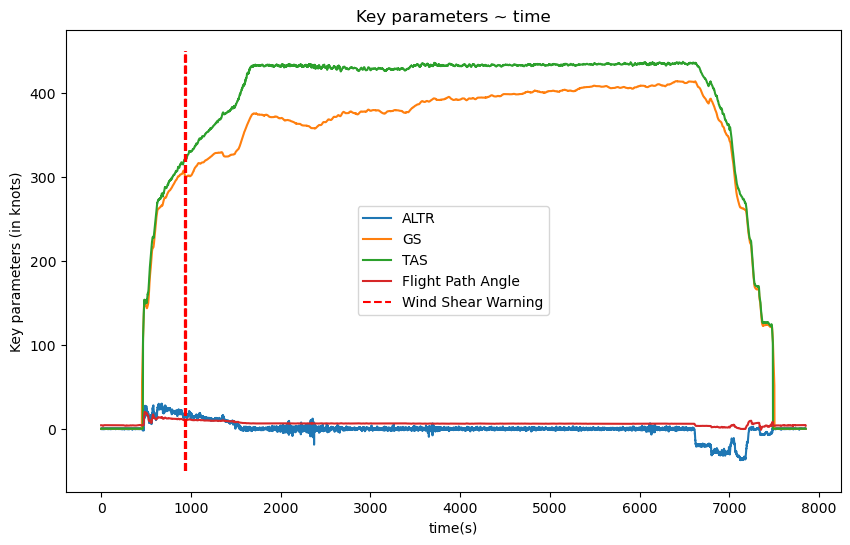

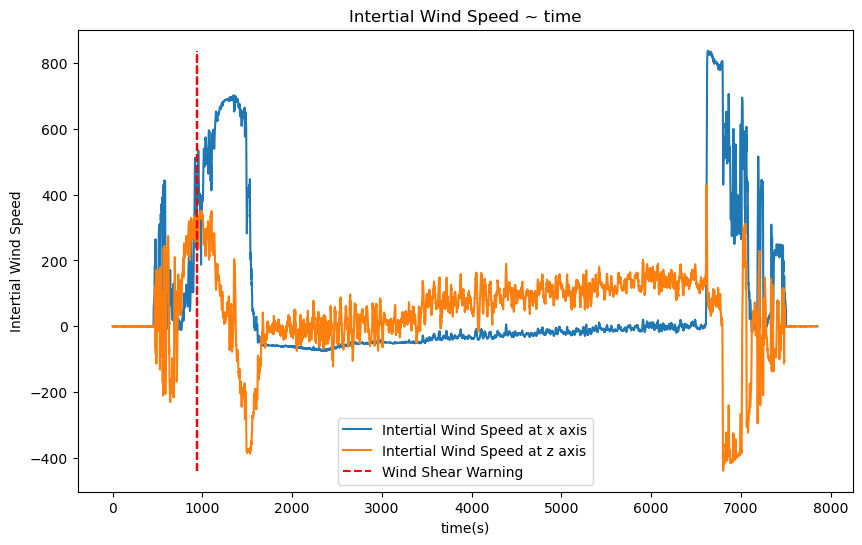

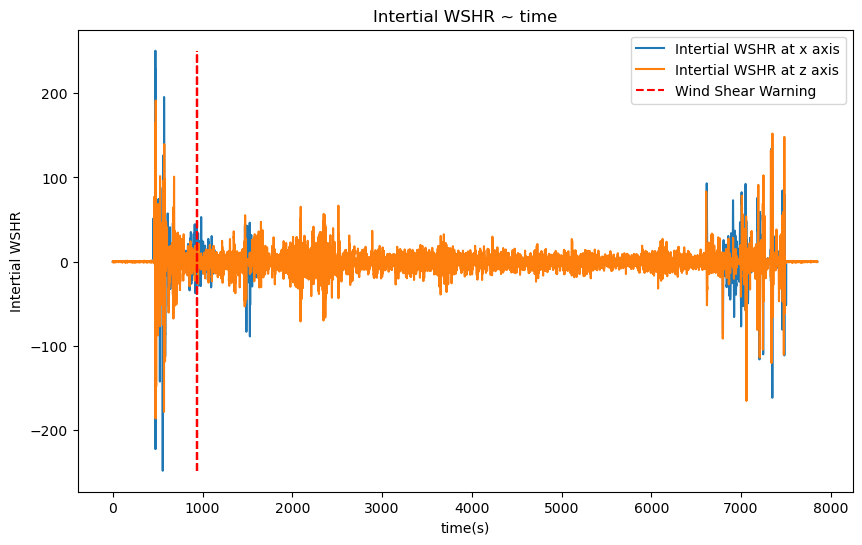

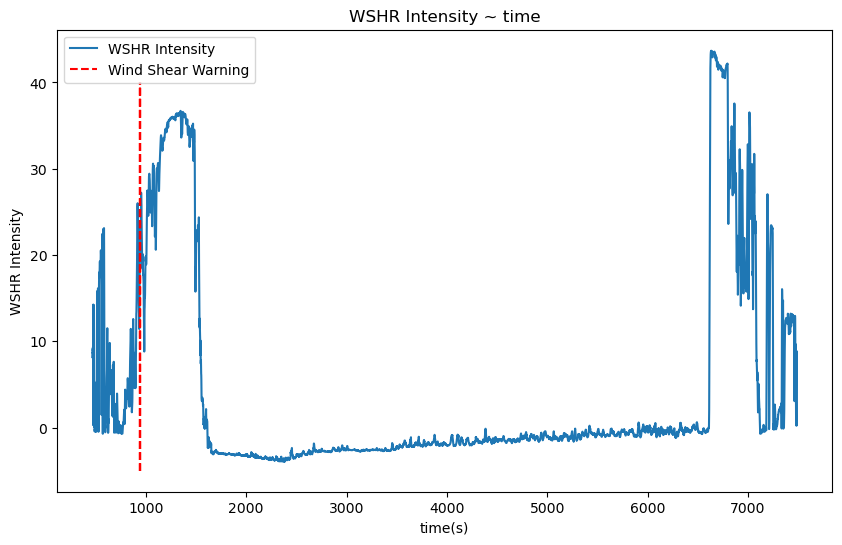

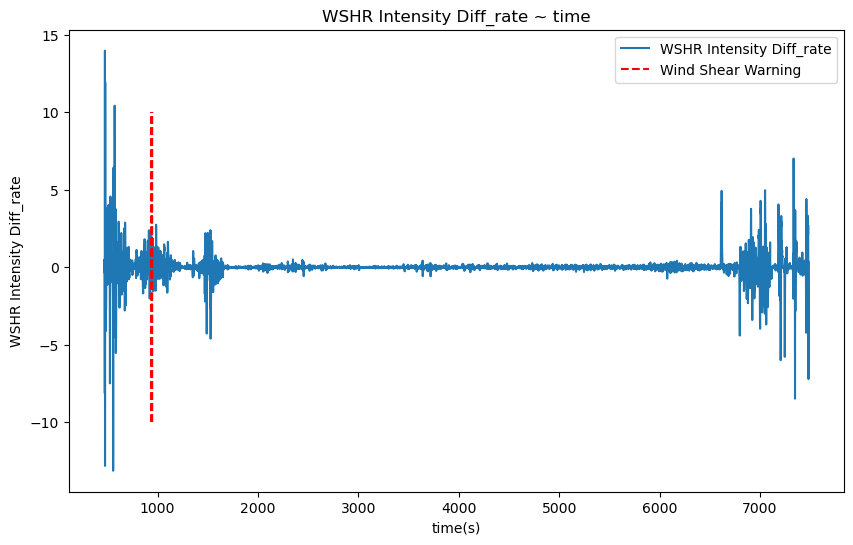

In [4]:
import wshrRelabelLight as WRL
import os
import numpy as np
import matplotlib.pyplot as plt

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# 指定读取变量名称
'''
GLS和TRK都不是飞行路径角
'''
variable_list = ['ALTR', 'GS', "TAS", 'PTCH', 'AOA1', 'AOA2', 'WS', "WD"]

train_folder_path = exception_folder_paths[3]
train_mat_name = os.listdir(train_folder_path)[2]
train_X, train_Y = WRL.dataConstruct(train_folder_path, train_mat_name, variable_list, normalized=False)

wshr_warn_idx_list = np.where(train_Y[:, 0] == 0)[0]
# print(wshr_warn_idx_list)

# 计算飞行轨迹角
flight_path_angle_X = train_X[:, 3] - np.mean(train_X[:, 4:5])

# 估算惯性风参数（x方向可能不准，因为地速可能需要再投影一次)
'''
注意：nasa数据集中ALTR的单位是英尺每分钟，TAS的单位是节；但是在运动公式里二者的单位都是节，需要换算
1节 = 101.27英尺每分钟
'''
intertial_wind_z = train_X[:, 0]/101.27 - train_X[:, 2]*np.sin(flight_path_angle_X)
intertial_wind_x = train_X[:, 1] - train_X[:, 2]*np.cos(flight_path_angle_X)

# 估算惯性风切变参数
intertial_wshr_z = intertial_wind_z[1:] - intertial_wind_z[:-1]
intertial_wshr_x = intertial_wind_x[1:] - intertial_wind_x[:-1]

# 计算风切变强度
g = 19.1
f = intertial_wind_x/g - intertial_wind_z/train_X[:, 2]
f_diff = f[1:] - f[:-1]

# 绘制ALTR、GS、TAS、飞行轨迹角等关键参数
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_X)), train_X[:, 0]/101.27, label='ALTR')
plt.plot(range(len(train_X)), train_X[:, 1], label='GS')
plt.plot(range(len(train_X)), train_X[:, 2], label='TAS')
plt.plot(range(len(train_X)), flight_path_angle_X, label='Flight Path Angle')
plt.vlines(wshr_warn_idx_list, -50, 450, colors='r', linestyles='--', label='Wind Shear Warning')
# plt.plot(range(len(train_X)), train_X[:, 2]*np.sin(flight_path_angle_X), label='TAS_partial_z')
plt.xlabel('time(s)')
plt.ylabel('Key parameters (in knots)')
plt.title('Key parameters ~ time')
plt.legend()
plt.show()

# 绘制估算的惯性风参数
plt.figure(figsize=(10, 6))
# plt.plot(range(len(train_X)), flight_path_angle_X, label='Flight Path Angle')
plt.plot(range(len(train_X)), intertial_wind_x, label='Intertial Wind Speed at x axis')
plt.plot(range(len(train_X)), intertial_wind_z, label='Intertial Wind Speed at z axis')
# plt.plot(range(len(train_X)), train_Y, c='red', label='Wind Shear Warning')
plt.vlines(wshr_warn_idx_list, min(min(intertial_wind_z), min(intertial_wind_x)), max(max(intertial_wind_z), max(intertial_wind_x)), colors='r', linestyles='--', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('Intertial Wind Speed')
plt.title('Intertial Wind Speed ~ time')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制估算的惯性风切变参数
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_X)-1), intertial_wshr_x, label='Intertial WSHR at x axis')
plt.plot(range(len(train_X)-1), intertial_wshr_z, label='Intertial WSHR at z axis')
# plt.plot(range(len(train_X)), train_Y, c='red', label='Wind Shear Warning')
plt.vlines(wshr_warn_idx_list, min(min(intertial_wshr_z), min(intertial_wshr_x)), max(max(intertial_wshr_z), max(intertial_wshr_x)), colors='r', linestyles='--', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('Intertial WSHR')
plt.title('Intertial WSHR ~ time')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制风切变强度
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_X)), f, label='WSHR Intensity')
# plt.plot(range(len(train_X)), train_Y, c='red', label='Wind Shear Warning')
plt.vlines(wshr_warn_idx_list, -5, 40, colors='r', linestyles='--', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('WSHR Intensity')
plt.title('WSHR Intensity ~ time')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制风切变强度变化率
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_X)-1), f_diff, label='WSHR Intensity Diff_rate')
# plt.plot(range(len(train_X)), train_Y, c='red', label='Wind Shear Warning')
plt.vlines(wshr_warn_idx_list, -10, 10, colors='r', linestyles='--', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('WSHR Intensity Diff_rate')
plt.title('WSHR Intensity Diff_rate ~ time')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_X)), flight_path_angle_X, label='Flight Path Angle')

array([-1.98532397])

In [ ]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data):
    # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return sampling_data

def dataConstruct(work_folder_path, work_mat_name, normalized=False, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]

    if not is_all_variable:
        # 提取WS, WD, TAS并进行重采样
        variable_list = ["WS", "WD", "TAS"]
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)

    # 绘制X的时间变化
    plt.figure()
    plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
    plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
    plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
    plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    plt.xlabel('time(s)')
    plt.ylabel('WS/WD/TAS & WSHR')
    plt.title('WS/WD/TAS and WSHR')
    plt.legend()
    # if np.std(X[:, 2]) > 1e-1:
    #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    plt.show()

    # 获取风切变警报时刻
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    if normalized:
        # 数据标准化
        s_scaler = StandardScaler()
        X = s_scaler.fit_transform(X)

    if not is_all_variable:
        # 绘制X的时间变化
        plt.figure()
        plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
        plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
        plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
        plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
        plt.xlabel('time(s)')
        plt.ylabel('WS/WD/TAS & WSHR')
        plt.title('Normalized WS/WD/TAS and WSHR')
        plt.legend()
        # if np.std(X[:, 2]) > 1e-1:
        #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
        plt.show()

        # 绘制X的三维散点图
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
        ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
        ax.set_xlabel(variable_list[0])
        ax.set_ylabel(variable_list[1])
        ax.set_zlabel(variable_list[2])
        ax.legend()
        plt.tight_layout()
        plt.show()

    return X, Y